# Satellites Characterization
** EE-558, A Network Tour of Data Science ** <br>
** Lucas Gauchoux, Laurier Loiselle, Antoine Weber **

# 0. Abstract

# 1. Imports, global names and helper functions

In [98]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from numpy import pi
import ephem
from tqdm import tqdm
import reverse_geocoder as rg
from collections import Counter
import networkx as nx
from multiprocessing import Pool
from scipy import sparse, stats, spatial, linalg
from pygsp import graphs, filters, plotting
from mpl_toolkits.basemap import Basemap
import sklearn
import itertools
import matplotlib as mpl
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

In [2]:
def read_tle(tle_file):
    tle = open(tle_file)
    lines = tle.readlines()
    return lines

In [3]:
def compute_tle_informations(lines):
    numb_element = len(lines)
    names = []
    long = []
    lat = []
    elevation_km = []
    for i in range(0,numb_element-1,3):
        temp = ephem.readtle(lines[i], lines[i+1], lines[i+2])
        temp.compute('2017/10/12')
        try:
            long.append(temp.sublong*180/pi)
            lat.append(temp.sublat*180/pi)
            elevation_km.append(temp.elevation/1000)
            names.append(temp.name[2:])
        except:
            print('Index number {} is not compatible to perform computation' .format(i))
    return names,long,lat,elevation_km

In [74]:
def satellite_orbit(name,sioi,dict_tle):
    nb_point = 200
    orbit_point = []
    period = int(sioi[sioi.OBJECT_NAME == name].PERIOD.values[0])
    delta_t = int(period*60/nb_point)
    delta_t = timedelta(seconds = delta_t)
    time = datetime(2017,10,12)
    l1, l2 = dict_tle[name]
    temp = ephem.readtle(name, l1, l2)
    for i in range(nb_point):
        time = time + delta_t
        temp.compute(time)
        try:
            lat = temp.sublat*180/pi
            long = temp.sublong*180/pi
            orbit_point.append((lat,long))
        except:
            print("ERROR")
    return orbit_point

In [5]:
def compute_grids(res):
    orbit_grids= []
    vertical_offset =90
    horizontal_offset = 180
    shape = (180,360)
    coverage_width = range(-7, 7)
    for stats in res:
        grid = np.zeros(shape)
        for lat, long in stats:
            lat = round(lat) + vertical_offset
            long = round(long) + horizontal_offset
            for i in coverage_width:
                for j in coverage_width:
                    grid[(lat+i)%shape[0]][(long+j)%shape[1]] = 1
        orbit_grids.append(grid)
    return orbit_grids

In [6]:
def plot_map(data_final,labels1=None,label_value=None):
    plt.figure(figsize=(20,10))
    eq_map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
                  lat_0=0,lon_0=0)
    eq_map.drawcoastlines()
    eq_map.drawcountries()
    eq_map.bluemarble()
    eq_map.drawmapboundary()
    eq_map.drawmeridians(np.arange(0, 360, 30))
    eq_map.drawparallels(np.arange(-90, 90, 30))

    if labels1 is not None:
        long = data_final['Longitude [°]'].values[labels1==label_value]
        lat = data_final['Latitude [°]'].values[labels1==label_value]
    else:
        long = data_final['Longitude [°]'].values
        lat = data_final['Latitude [°]'].values
    lons,lats = eq_map(long,lat)
    eq_map.scatter(lons, lats, marker = 'o', color='y', zorder=1)
    plt.show()

In [7]:
def dbscan_func(G,epsilon,mn,labels=None,label_value=None):
    centers = [[1, 1], [-1, -1], [1, -1]]
    
    if labels is not None:
        X = G.coords[labels==label_value]
    else:
        X = G.coords
        
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps= epsilon, min_samples = mn).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels1 = db.labels_

    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
    unique_labels = set(labels1)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels1 == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return labels1

In [8]:
def compute_weight(sat1,sat2):
    tot = np.logical_and(sat1,sat2)
    return np.sum(tot)

In [9]:
def compute_adja(orbit_grids):
    adja = np.zeros([len(orbit_grids),len(orbit_grids)])
    for n1,i1 in enumerate(orbit_grids):
        for n2,i2 in enumerate(orbit_grids[n1+1:]):
            adja[n1,n2+n1+1] = compute_weight(i1,i2)
    return adja + np.transpose(adja)

# 2. Data Acquisition

# 3. Data Exploration

Presentation of the two main file used for the clustering of the main orbit

Description of the concepts of a TLE file + PyEphem library

In [11]:
lines_tot = read_tle('Dataset/satellite_tle_current.txt')
assert [lines_tot.count('\n') == 0]

names,long,lat,elevation_km = compute_tle_informations(lines_tot)
data = pd.DataFrame(np.transpose([names,long,lat,elevation_km]))
data.columns = ['OBJECT_NAME','Longitude [°]','Latitude [°]','Elevation [km]']

Index number 5361 is not compatible to perform computation
Index number 49563 is not compatible to perform computation


In [12]:
coord = list(zip(lat,long))
result = rg.search(coord)
countries = [temp['cc'] for temp in result]
data['Country'] = countries

Loading formatted geocoded file...


In [18]:
data.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]  \
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125   
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825   
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875   
3  VANGUARD R/B  -117.00344908625789   12.395302654786787    2056.953375   
4    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14   

  Country  
0      AR  
1      ZA  
2      FM  
3      MX  
4      SH

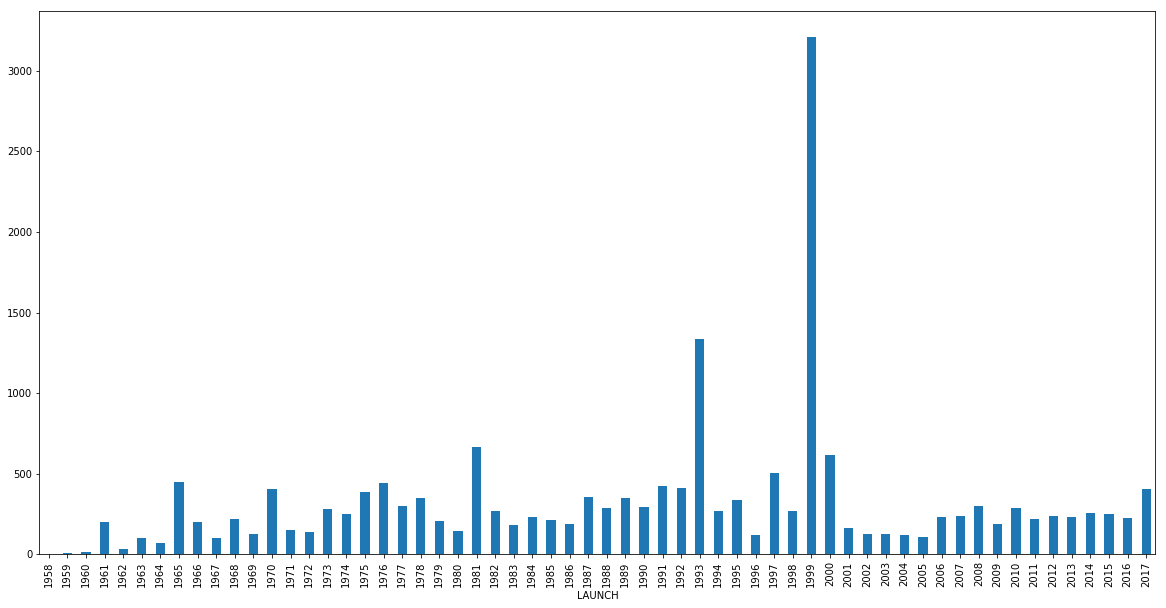

In [16]:
sioi = pd.read_csv("Dataset/satellites_in_orbit_info.csv")
sioi["LAUNCH"]= pd.to_datetime(sioi["LAUNCH"]).apply(lambda x: x.strftime('%Y'))
sioi.groupby("LAUNCH").size().plot(kind="bar", figsize=(20,10))
plt.show()

Try to expalin the peak in 1993 and 1999.

Exploration of the other scrapped files even if not used

In [29]:
sspc = pd.read_csv("Dataset/sat_statistics_per_country.csv")
sspc_dec = sspc[["COUNTRY", "DECAYED_TOTAL_COUNT"]].set_index("COUNTRY")
sspc = sspc[["COUNTRY", "ORBITAL_TOTAL_COUNT"]].set_index("COUNTRY")

sspc = sspc.drop("ALL")
sspc_dec= sspc_dec.drop("ALL")

In [30]:
sspc_dec.head()

DECAYED_TOTAL_COUNT
COUNTRY                                                        
ARAB SATELLITE COMMUNICATIONS ORGANIZATION                    1
ASIASAT CORP                                                  0
ALGERIA                                                       0
ARGENTINA                                                     2
AUSTRIA                                                       0

Giving information about the number of decayed satellite per country. Filter the country having 0 decayed count

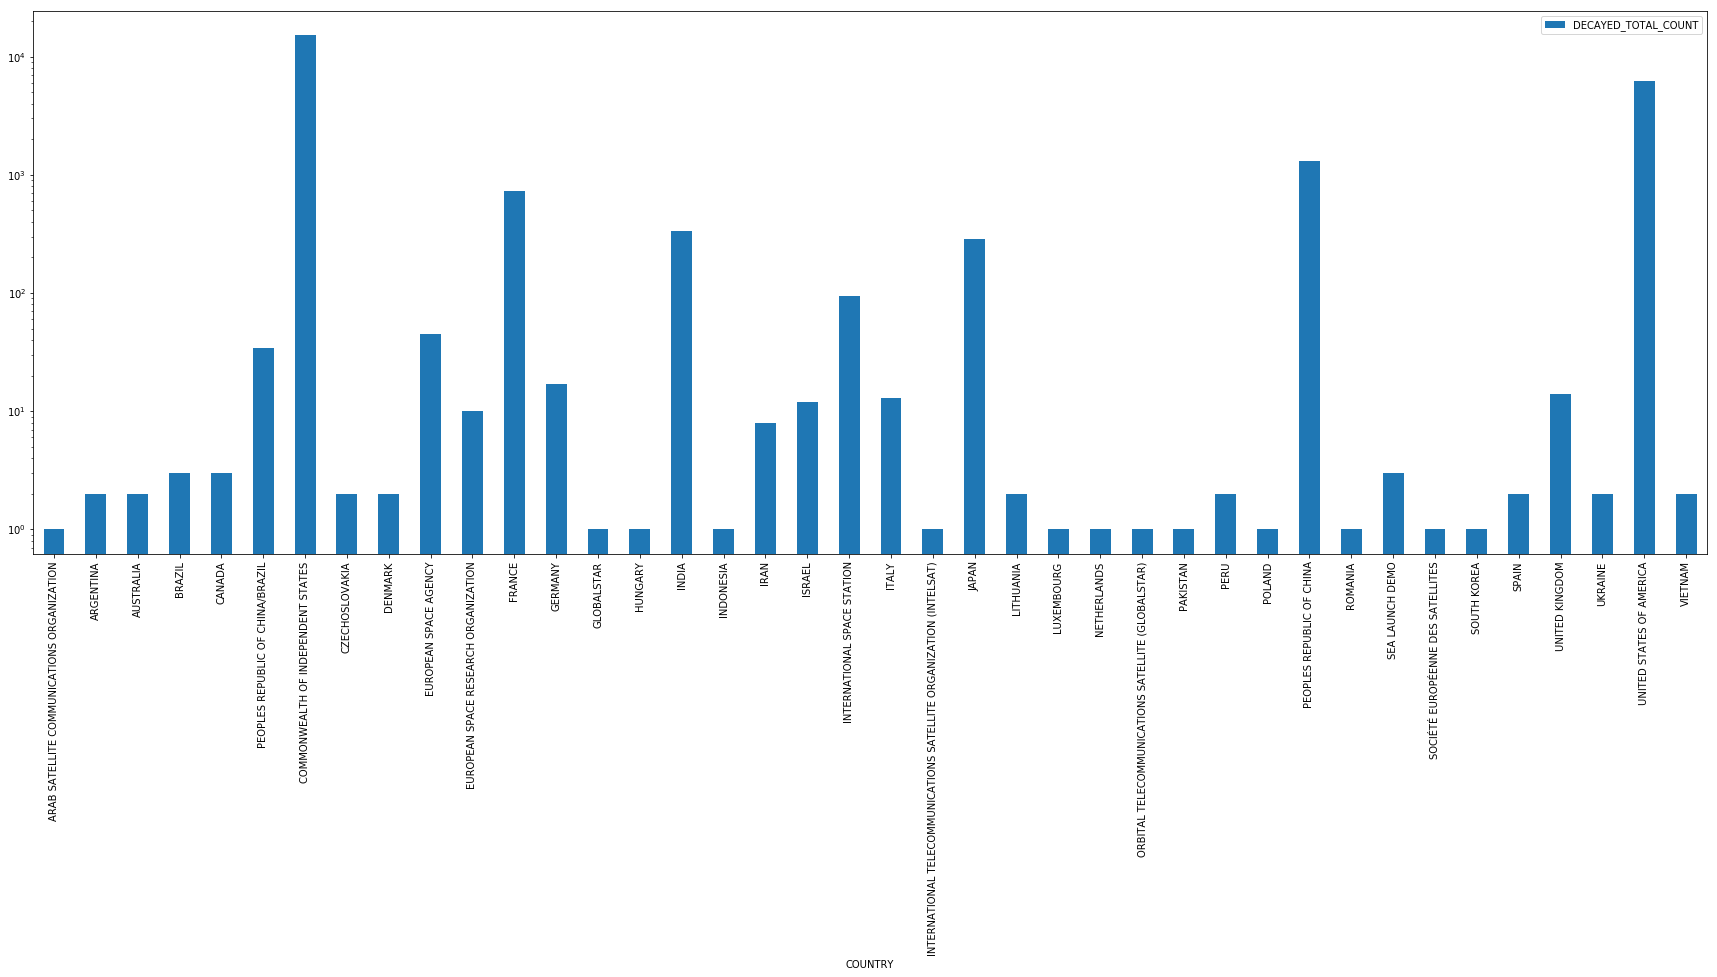

In [33]:
sspc_dec = sspc_dec[sspc_dec["DECAYED_TOTAL_COUNT"] > 0]
sspc_dec.plot(kind='bar', figsize = (30, 10), logy=True)
plt.show()

number of satellites in orbit per country

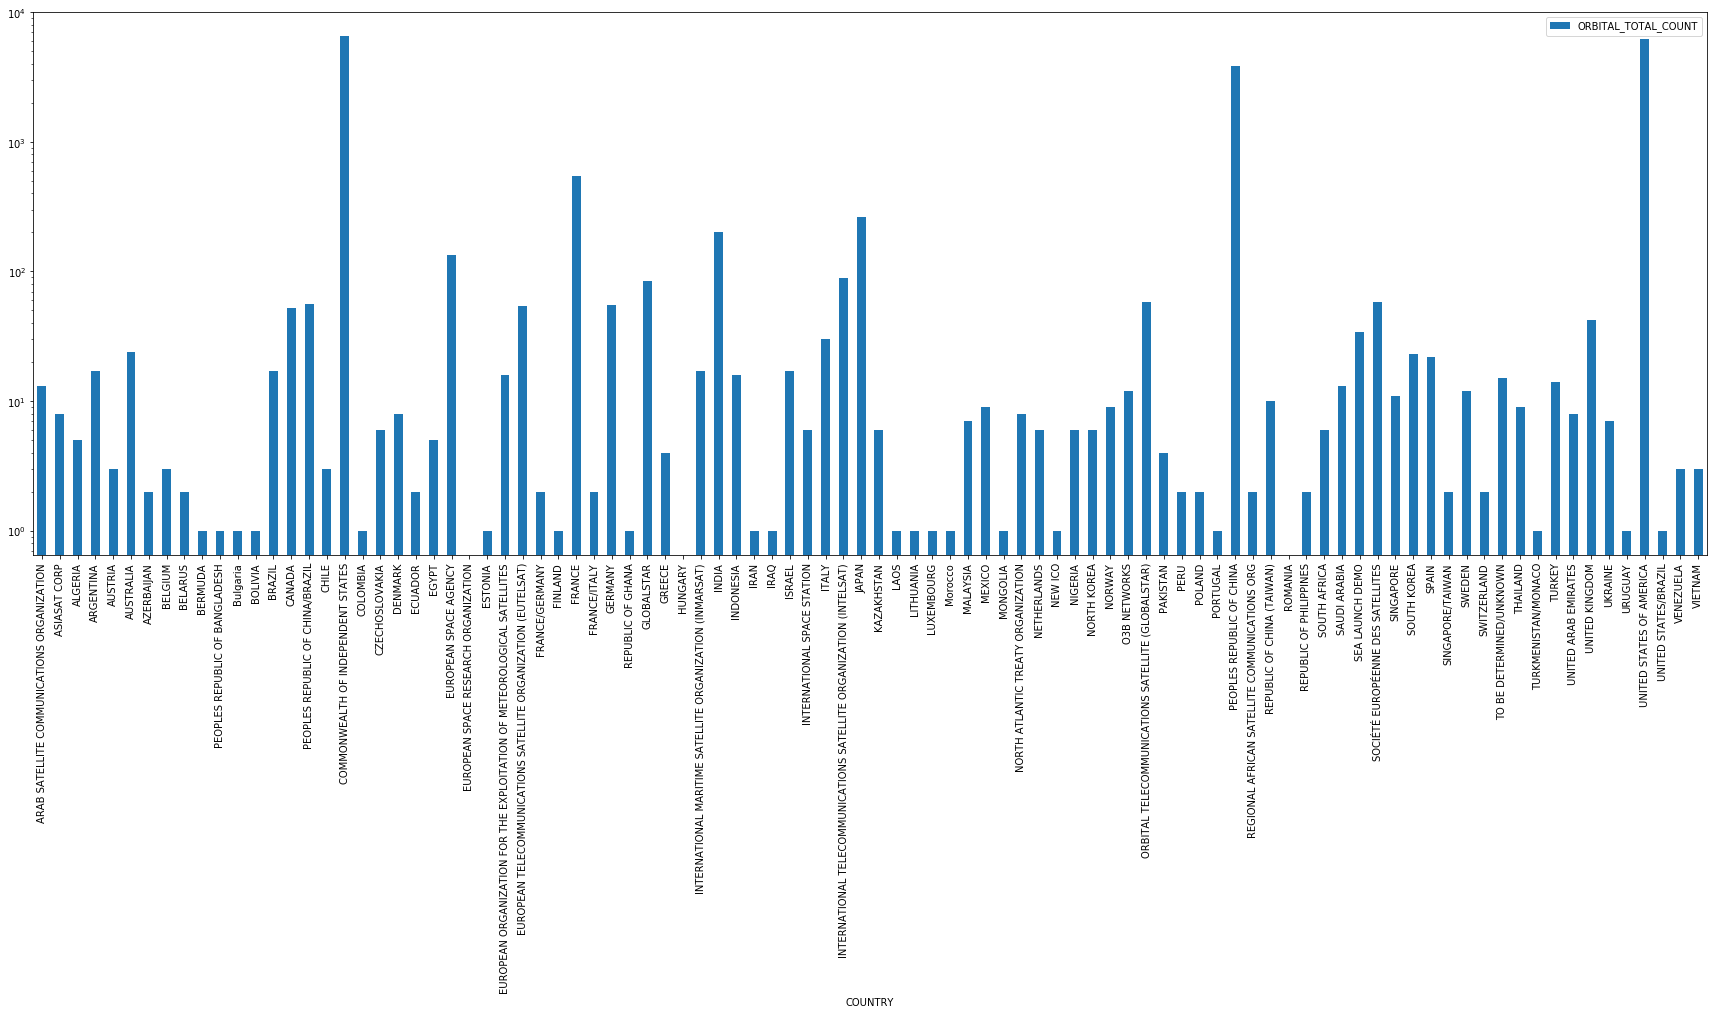

In [34]:
sspc.plot(kind='bar', figsize = (30, 10), logy=True)
plt.show()

In [55]:
np.shape(sioi)

(4951, 12)

In [56]:
np.shape(data)

(16729, 5)

Merging the tle and satellite in orbit info files

In [35]:
no_deb = data[["DEB" not in x for x in data.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
sioi = sioi[["DEB" not in x for x in sioi.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
data_m = pd.merge(no_deb,sioi,how='inner', on="OBJECT_NAME")
#mask = (data_m['Elevation [km]'].astype('float64') < 30000)
#data_final = data_m[mask]
data_final = data_m.dropna(axis= 0, subset=["PERIOD"])

In [36]:
data_final.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]  \
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125   
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825   
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875   
3    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14   
4    EXPLORER 7    165.9903034740197    9.845133707399345   517.82565625   

  Country  OBJECT_ID  NORAD_CAT_ID COUNTRY  PERIOD  INCLINATION  APOGEE  \
0      AR  1958-002B             5      US  132.75        34.24  3834.0   
1      ZA  1959-001A            11      US  121.47        32.87  2940.0   
2      FM  1958-002A            16      US  137.32        34.28  4223.0   
3      SH  1959-007A            20      US  124.62        33.35  3263.0   
4      MH  1959-009A            22      US   96.36        50.28   683.0   

   PERIGEE RCS_SIZE  RCSVALUE LAUNCH COMMENT  
0    650.0   MEDIUM         0   1958     NaN  
1    553.0   MEDIUM         0   1959     NaN  
2    655.0   MEDIUM         0   1958     NaN  
3    510.0   MEDIUM         0   1959     NaN  
4    486.0   MEDIUM         0   1959     NaN

In [37]:
np.shape(data_final)

(4347, 16)

TODO : Exploratory of the satcat file (clean)

## 4. Data Exploitation

** First investigation :**
We know from the XXXXXXXXX website that the main satellute orbit follow a certain shape. Try to cluster this using only the TLE.

In [38]:
dict_tle = {}
for i in range(0,len(lines_tot)-1,3):
    dict_tle[lines_tot[i][2:].strip('\n')] = (lines_tot[i+1],lines_tot[i+2])
    
keys = list(dict_tle.keys())
for i in keys:
    if i not in data_final['OBJECT_NAME'].values:
        del dict_tle[i]

In [75]:
res = []
for i in (dict_tle.keys()):
    res.append(satellite_orbit(i,sioi,dict_tle))

In [76]:
orbit_grids = compute_grids(res)

Here are some typical results we got with the computation of the overflown areas

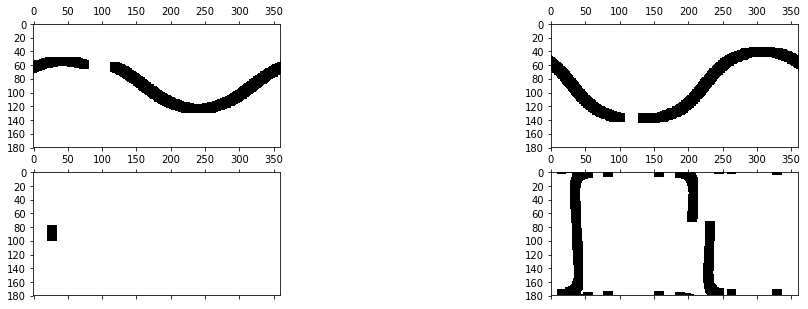

In [122]:
fig, axes = plt.subplots(2,2)
axes[0,0].spy(orbit_grids[0])
axes[0,1].spy(orbit_grids[5])
axes[1,0].spy(orbit_grids[200])
axes[1,1].spy(orbit_grids[150])

Apparently there is a small gap. Problem with the period sampling

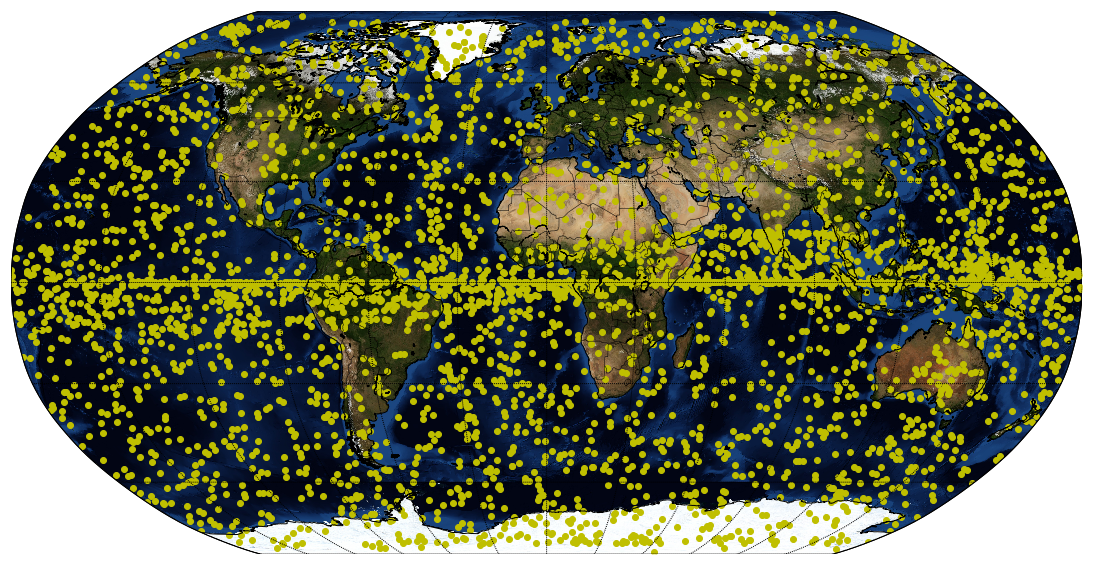

In [78]:
plot_map(data_final)

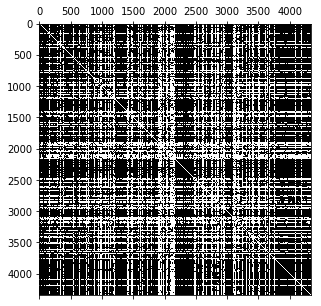

In [79]:
adja = compute_adja(orbit_grids)
plt.spy(adja)

All the blanks -> geostationary

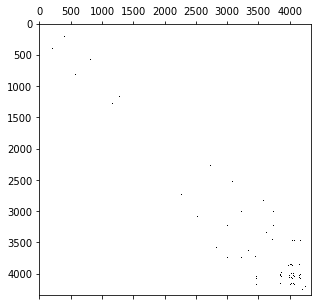

In [105]:
final = adja*(adja>8000)
plt.spy(final)

apply a threshold to keep only highly connected

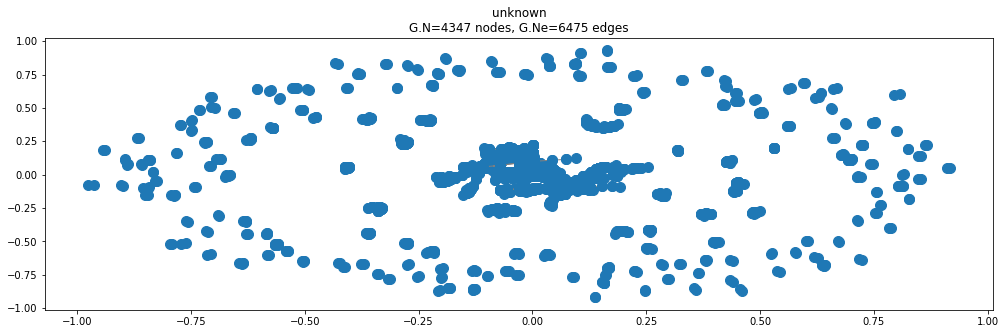

In [106]:
G = graphs.Graph(final)
G.set_coordinates('spring')
G.plot()

Visualize the graph in a spring manner using PyGSP

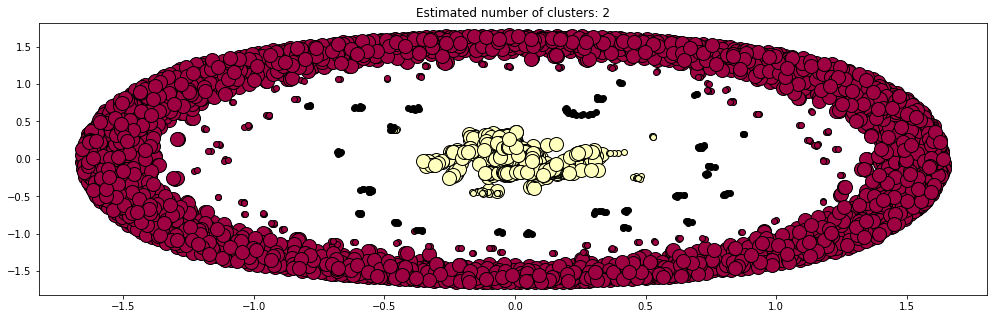

In [107]:
labels1 = dbscan_func(G,0.3,100)

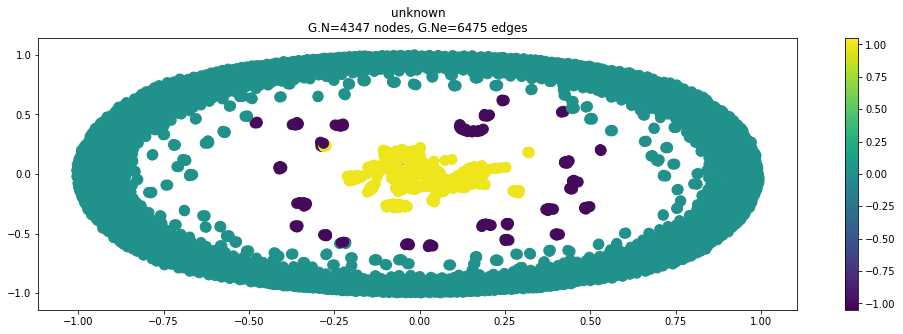

In [108]:
G.plot_signal(labels1)

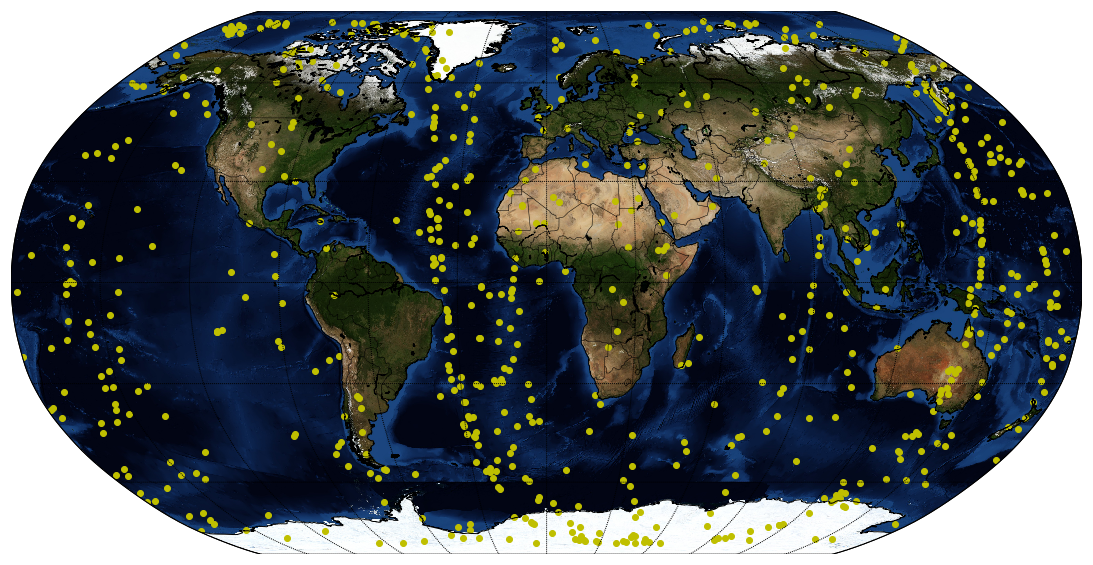

In [109]:
plot_map(data_final,labels1,1)

We can see different phase. Try to differenciate them

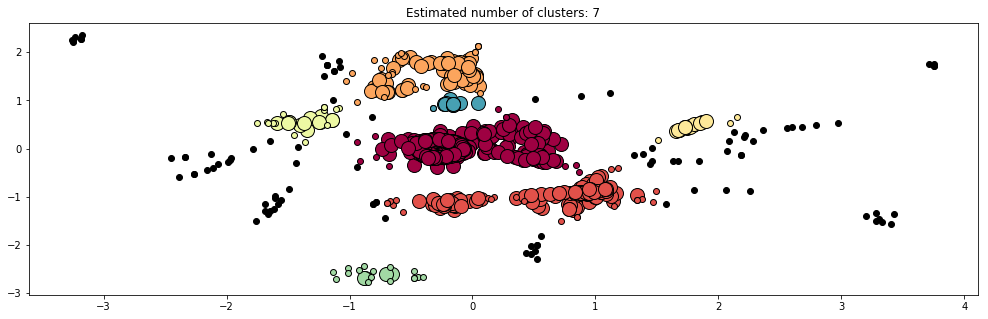

In [111]:
labels2 = dbscan_func(G,0.3,15,labels1,1)

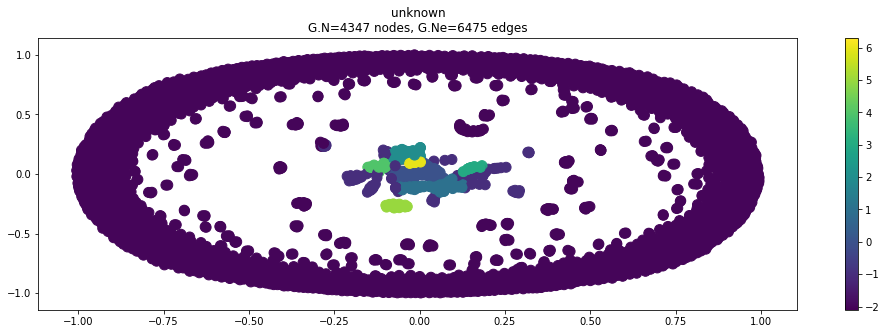

In [112]:
indices = np.where(labels1==1)
labels3 = np.ones(len(labels1))*(-2)
labels3[[indices]] = labels2
G.plot_signal(labels3)

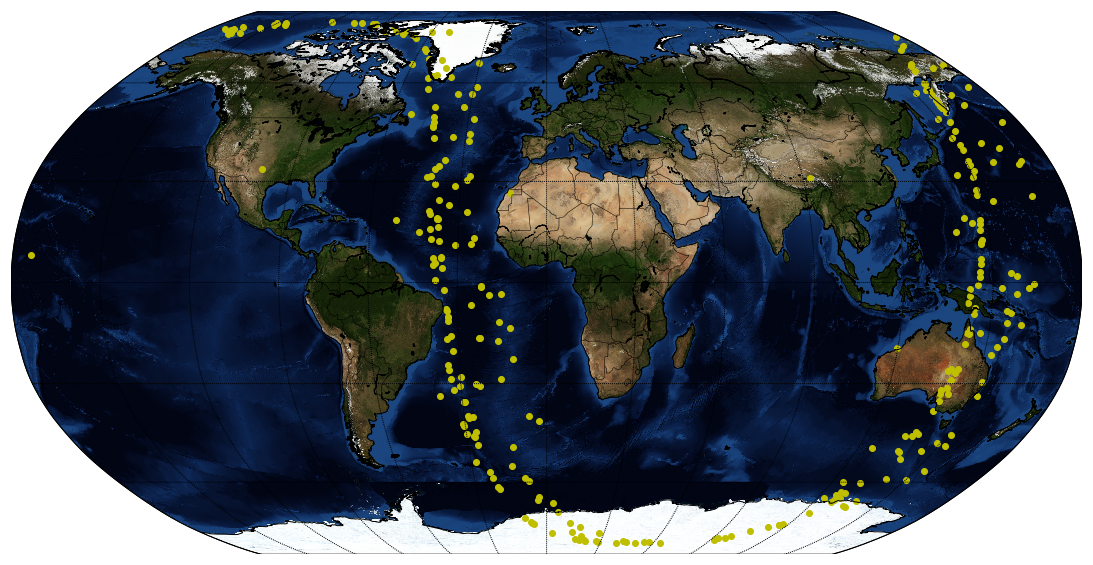

In [113]:
plot_map(data_final,labels3,0)

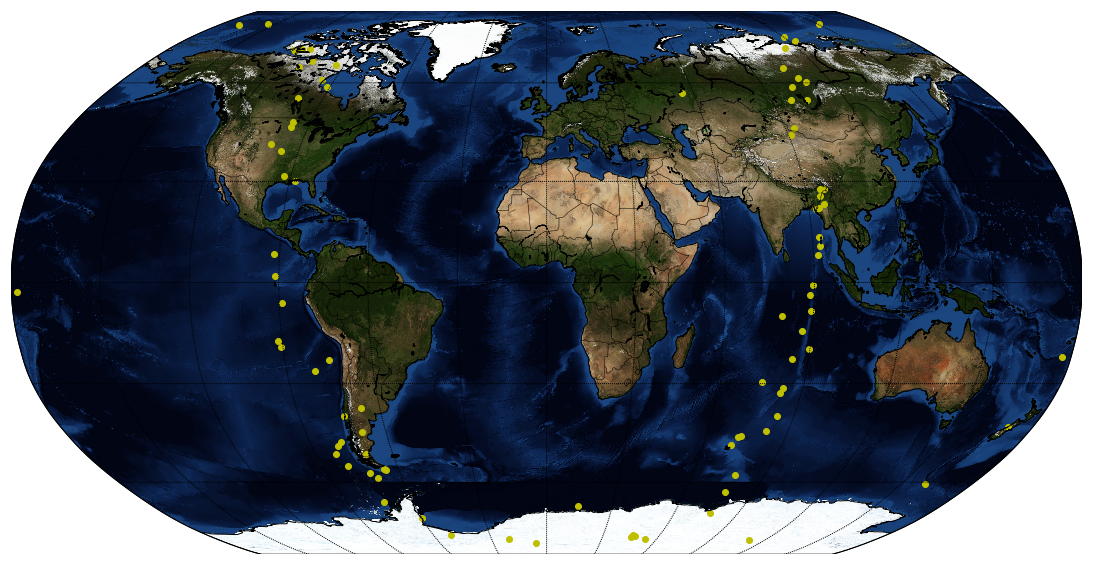

In [117]:
plot_map(data_final,labels3,2)

Nicely clustered. Able to differenciate the phases

** Bonus : ** <br>
Visualise the geostationary satellites

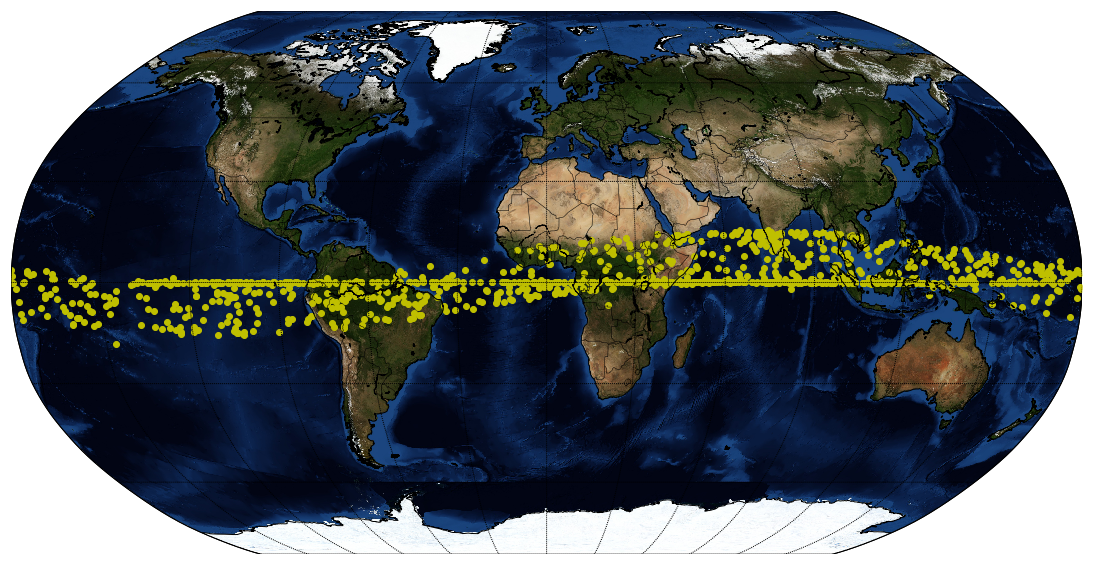

In [118]:
summ = np.zeros([len(orbit_grids),1])
for n,i in enumerate(orbit_grids):
    summ[n] = np.sum(i)
summ = summ*(summ<1000)
mask = summ>0
mask = (mask==True).T[0]
plot_map(data_final,mask.T,True)